# Import data from https://tradingeconomics.com/matrix 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from bs4 import BeautifulSoup as bs
import requests

In [60]:
url="https://tradingeconomics.com/matrix"

# Import matrix data 

In [3]:
df=pd.read_html(url)[0]

In [4]:
df.columns=df.columns.str.replace(" ","",regex=True)
df["Country"]=df["Country"].str.replace(" ","")

In [5]:
df

,Country,GDP,GDPYoY,GDPQoQ,InterestRate,InflationRate,JoblessRate,Gov.Budget,Debt/GDP,CurrentAccount,Population
0,UnitedStates,20937,3.5,-1.6,1.75,8.60,3.6,-16.7,137.2,-3.6,332.40
1,China,14723,4.8,1.3,3.70,2.10,5.9,-3.7,66.8,1.8,1412.60
2,EuroArea,13011,5.4,0.6,0.00,8.10,6.6,-5.1,95.6,3.0,342.41
3,Japan,4975,0.2,-0.1,-0.10,2.50,2.5,-12.6,266.2,3.2,125.67
4,Germany,3846,3.8,0.2,0.00,7.60,5.3,-3.7,69.3,7.0,83.17
...,...,...,...,...,...,...,...,...,...,...,...
176,GuineaBissau,1,5.8,NaN,4.00,6.70,3.2,-7.8,36.5,-8.6,1.96
177,Comoros,1,2.2,NaN,0.92,3.59,9.4,-2.9,31.1,-3.3,0.87
178,Seychelles,1,0.1,NaN,2.00,2.10,3.0,-19.1,94.0,-27.4,0.10
179,SouthSudan,1,-6.0,NaN,12.00,-4.29,13.9,NaN,NaN,NaN,11.19


# Extract detailed data for each country 

### create a dictionary of countries and thier detailed data

In [6]:
page=requests.get(url,headers={'User-Agent': 'Mozilla/5.0'}).content
soup=bs(page,"html.parser")

dfs={}
countries=soup.select("div[class='container'] div[class='row'] table[id='matrix']       tr td:nth-child(1) a")
for country in countries[:10]:                                                          # select number of countries!!!
    title=country.text.replace(" ","")
    url2="https://tradingeconomics.com"+country["href"]
    soup=bs(requests.get(url2,headers={'User-Agent': 'Mozilla/5.0'}).content,"html.parser")
    tabs=soup.select("ul[class='nav nav-tabs'] li a")
    data=pd.DataFrame()
    for tab,i in zip(tabs,range(len(tabs)+1)):
        header=tab.text
        url3=url2+tab["href"]
        df=pd.read_html(url3)[i]
        df['Country']=title
        data=pd.concat([data,df],ignore_index=True)
    data=data.rename(columns={"Unnamed: 0":"KPI","Unnamed: 3":"ValueIn","Unnamed: 4":"Period"})
    data=data.drop_duplicates(keep="first")
    dfs[title]=data
    

# Plot data 

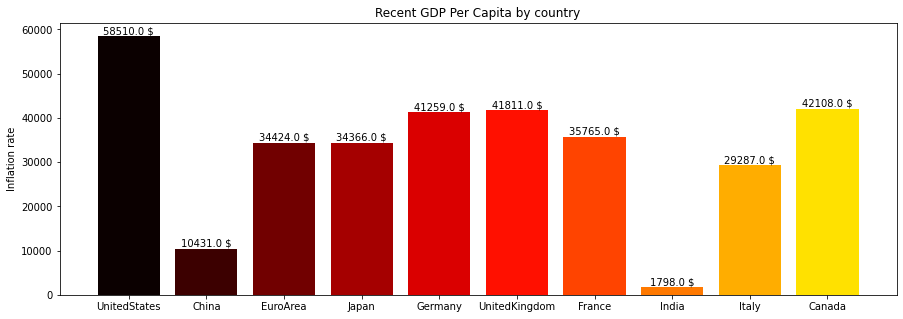

In [66]:
import matplotlib.ticker as mtick

plt.figure(figsize=(15,5))
colors=list(plt.get_cmap("hot")(np.linspace(0,0.7,len(dfs))))


for i,(key, value) in enumerate(dfs.items()):
    value=value[(value.KPI=="GDP per capita")]
    plt.bar(value.Country,value.Last,color=colors[i])
    plt.ylabel("Inflation rate")
    plt.title("Recent GDP Per Capita by country")
    plt.text(i,value.Last,str(value.Last.iloc[0])+" $",va="bottom",ha="center")

   


# Union every dataframe into one  

In [8]:
unioned=pd.DataFrame()
for key,value in dfs.items():
    unioned=pd.concat([unioned,value])

# Plot data 

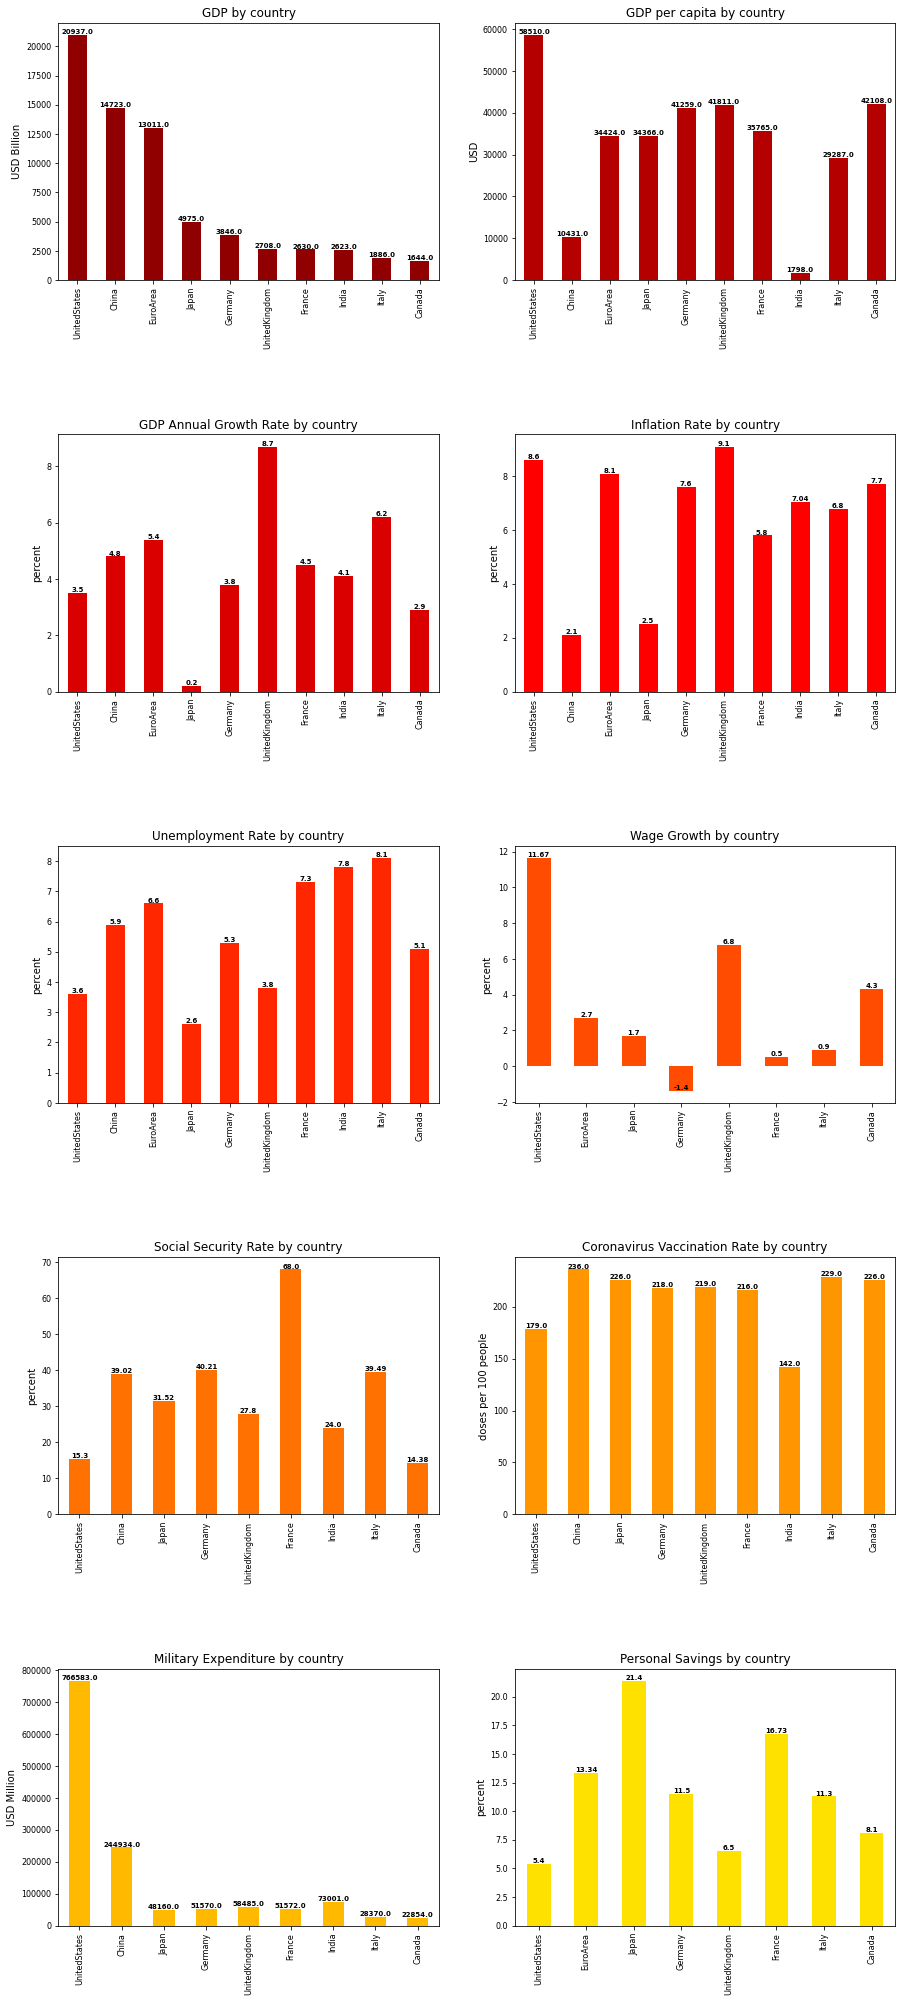

In [59]:
KPIs=["GDP","GDP per capita","GDP Annual Growth Rate","Inflation Rate","Unemployment Rate","Wage Growth",\
      "Social Security Rate","Coronavirus Vaccination Rate","Military Expenditure","Personal Savings"]
fig,axes=plt.subplots(5,2,figsize=(15,35))
colors=list(plt.get_cmap("hot")(np.linspace(0.2,0.7,len(KPIs))))

for KPI,ax,c in zip(KPIs,axes.ravel(),colors):
    filtered=unioned[unioned.KPI==KPI]
    filtered.plot(kind="bar",ax=ax,x="Country",y=["Last"],xlabel="",ylabel=filtered["ValueIn"].iloc[0],legend=False,fontsize=8,color=c)
    ax.set_title(KPI+" by country")
    plt.subplots_adjust(hspace=0.6)
    for i,y in enumerate(filtered.Last):
        ax.text(i,y,y,size=7,ha="center",va="bottom",fontweight="bold")
plt.show()
    